In [ ]:
!pip install --quiet pycocotools ultralytics

In [ ]:
import os
import torch
import random
import json
import glob

import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T
import matplotlib.patches as patches

from shutil import copyfile
from scipy.optimize import linear_sum_assignment
from torchvision import transforms
from PIL import Image
from ultralytics import YOLO
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pathlib import Path
from collections import defaultdict
from torchvision.ops import box_iou
from tqdm import tqdm

In [ ]:
JPEGImages = '/kaggle/input/pascal-voc-2012/VOC2012/JPEGImages'
VAL_TXT = '/kaggle/input/pascal-voc-2012/VOC2012/ImageSets/Main/val.txt'
TARGET = '/kaggle/working/voc2012_val_images'

os.makedirs(TARGET, exist_ok=True)

with open(VAL_TXT) as f:
    val_names = [line.strip() for line in f if line.strip()]

# Only copy if the file doesn't already exist (to avoid re-copying if re-run)
for name in val_names:
    src = os.path.join(JPEGImages, name + '.jpg')
    dst = os.path.join(TARGET, name + '.jpg')
    if not os.path.exists(dst):
        copyfile(src, dst)

print(f"Copied {len(val_names)} images to {TARGET}")

In [ ]:
# VOC 2012 standard class list
voc_labels = [
    'aeroplane','bicycle','bird','boat','bottle','bus','car','cat','chair','cow',
    'diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa',
    'train','tvmonitor'
]
categories = [{"id": i+1, "name": name} for i, name in enumerate(voc_labels)]

ann_dir = '/kaggle/input/pascal-voc-2012/VOC2012/Annotations'
val_txt = '/kaggle/input/pascal-voc-2012/VOC2012/ImageSets/Main/val.txt'
val_ann_json = '/kaggle/working/voc2012_val_coco.json'

# Get val image ids
with open(val_txt) as f:
    val_ids = set(x.strip() for x in f.readlines() if x.strip())

images, annotations = [], []
ann_id = 1
image_id_map = {}  # VOCfile: coco_id

for img_id, xml_name in enumerate(sorted(val_ids)):
    xml_file = os.path.join(ann_dir, xml_name + ".xml")
    if not os.path.isfile(xml_file):
        continue
    tree = ET.parse(xml_file).getroot()
    filename = tree.find("filename").text
    size = tree.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    images.append({
        "file_name": filename,
        "height": height,
        "width": width,
        "id": img_id
    })
    image_id_map[xml_name] = img_id

    for obj in tree.findall("object"):
        cname = obj.find("name").text
        if cname not in voc_labels:
            continue
        cid = voc_labels.index(cname) + 1
        bndbox = obj.find("bndbox")
        xmin, ymin, xmax, ymax = [int(float(bndbox.find(c).text)) for c in ("xmin","ymin","xmax","ymax")]
        w, h = xmax - xmin, ymax - ymin
        annotations.append({
            "id": ann_id,
            "image_id": img_id,
            "category_id": cid,
            "bbox": [xmin, ymin, w, h],
            "area": w * h,
            "iscrowd": 0
        })
        ann_id += 1

coco_dict = {
    "images": images,
    "annotations": annotations,
    "categories": categories
}
with open(val_ann_json, "w") as f:
    json.dump(coco_dict, f)
print(f"COCO annotation JSON for VOC 2012 validation set saved as: {val_ann_json}")

In [ ]:
# Data Paths
ANNOT_PATH = "/kaggle/working/voc2012_val_coco.json"
VAL_IMAGES = "/kaggle/working/voc2012_val_images"
OUTPUT_DIR = "/kaggle/working/yolo11_inference"
PRED_DIR = Path("/kaggle/working/yolo11_inference/JPEGImages_preds/labels")
OUTPUT_JSON = "/kaggle/working/yolo11_preds.json"

In [79]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load a COCO-pretrained YOLO11x model
model = YOLO("yolo11x.pt")
model.to(device)  # move model to GPU

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(96, 192, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C3k2(
        (cv1): Conv(
          (conv): Conv2d(192, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(192, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(384, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(384, eps=0.001, momentum=0.03, affine=True, track_

In [80]:
# Run inference
results = model.predict(
    source=VAL_IMAGES,      # folder of COCO val images
    save=True,              # save annotated images
    save_txt=True,          # save raw predictions (.txt per image)
    save_conf=True,         # save confidence in the .txt files
    project=OUTPUT_DIR,     # outputs go to /kaggle/working/yolov8_inference
    name="JPEGImages_preds",# subfolder name
    imgsz=640,              # inference size in pixels
    conf=0.25,              # confidence threshold
    batch=16                # process 16 images at once
)

print("Done – check:", os.path.join(OUTPUT_DIR, "JPEGImages_preds"))


image 1/5823 /kaggle/working/voc2012_val_images/2008_000002.jpg: 640x640 1 tv, 2 books, 28.8ms
image 2/5823 /kaggle/working/voc2012_val_images/2008_000003.jpg: 640x640 1 person, 1 train, 28.8ms
image 3/5823 /kaggle/working/voc2012_val_images/2008_000007.jpg: 640x640 1 boat, 28.8ms
image 4/5823 /kaggle/working/voc2012_val_images/2008_000009.jpg: 640x640 3 cows, 28.8ms
image 5/5823 /kaggle/working/voc2012_val_images/2008_000016.jpg: 640x640 2 tvs, 1 mouse, 1 keyboard, 28.8ms
image 6/5823 /kaggle/working/voc2012_val_images/2008_000021.jpg: 640x640 1 airplane, 28.8ms
image 7/5823 /kaggle/working/voc2012_val_images/2008_000026.jpg: 640x640 1 person, 1 dog, 28.8ms
image 8/5823 /kaggle/working/voc2012_val_images/2008_000027.jpg: 640x640 1 person, 3 cars, 1 truck, 28.8ms
image 9/5823 /kaggle/working/voc2012_val_images/2008_000032.jpg: 640x640 3 persons, 1 bus, 28.8ms
image 10/5823 /kaggle/working/voc2012_val_images/2008_000034.jpg: 640x640 3 persons, 1 bottle, 1 dining table, 28.8ms
image 11/

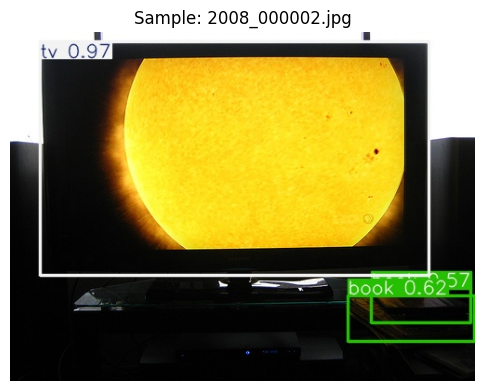

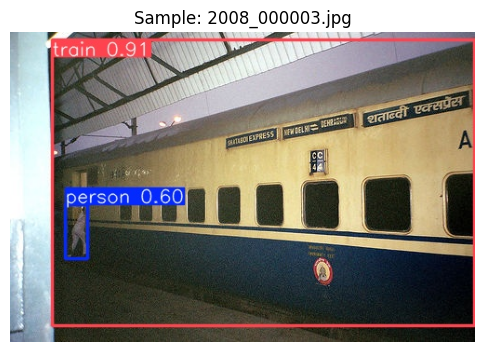

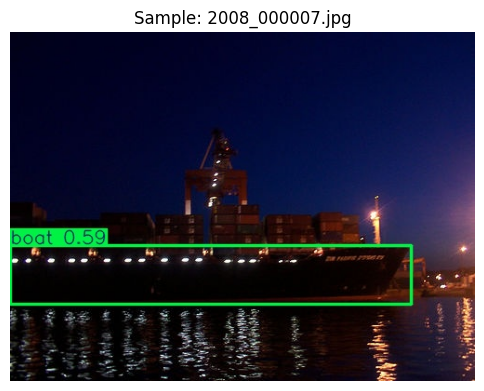

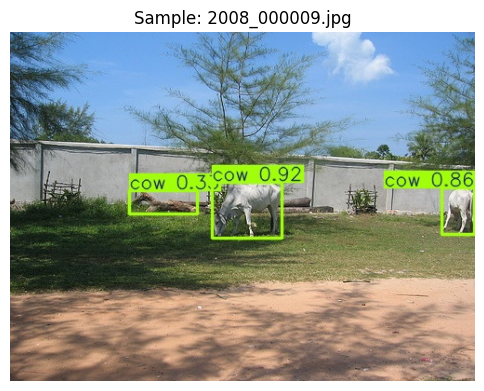

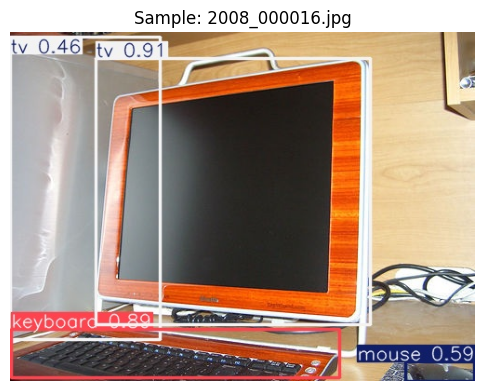

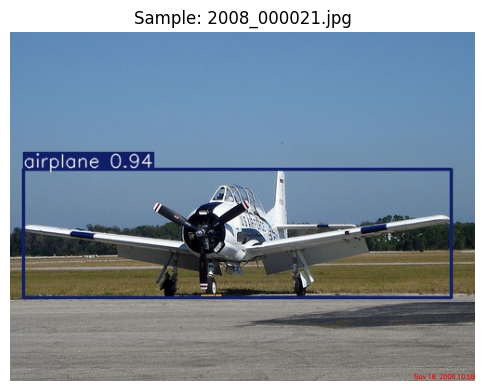

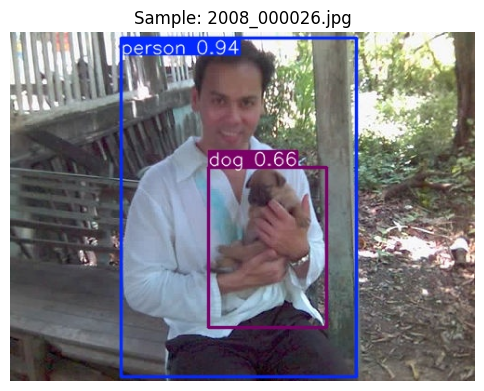

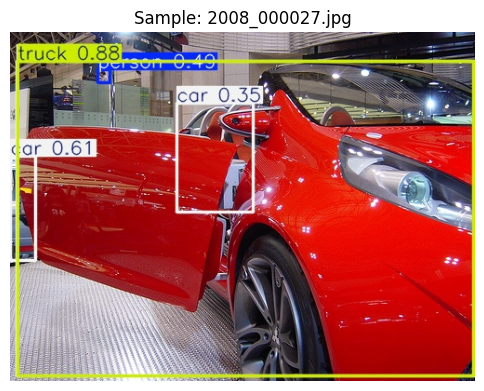

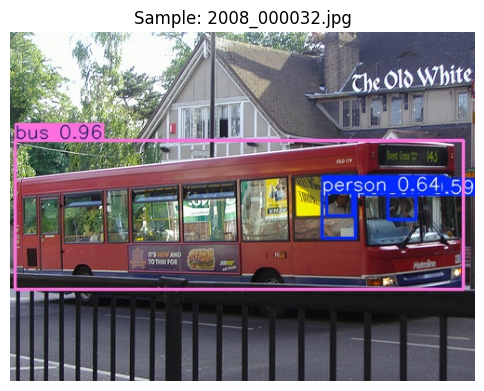

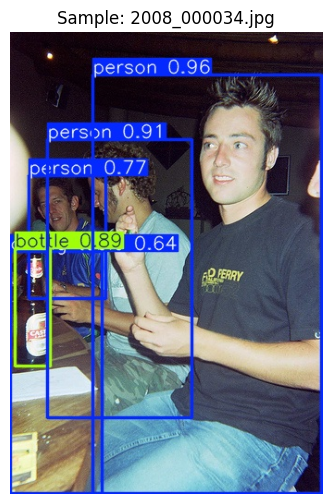

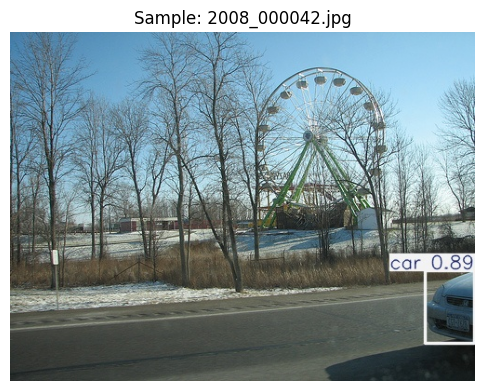

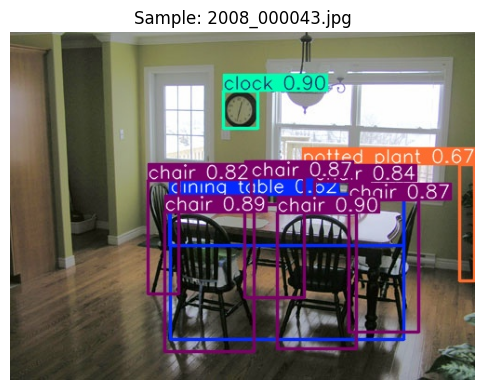

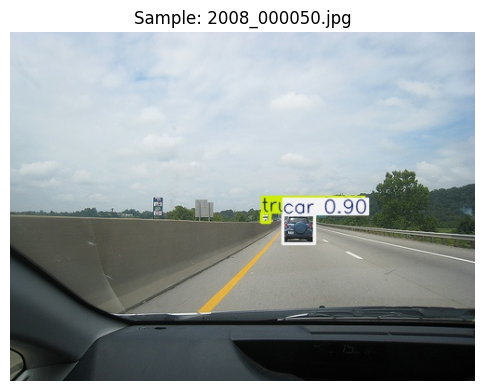

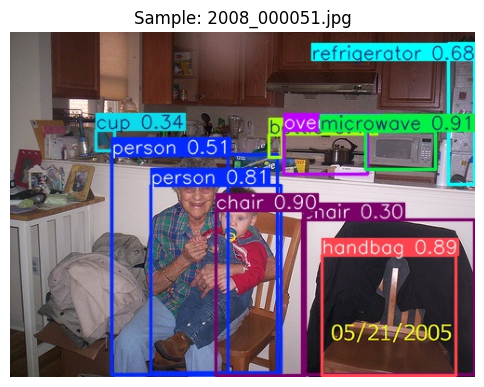

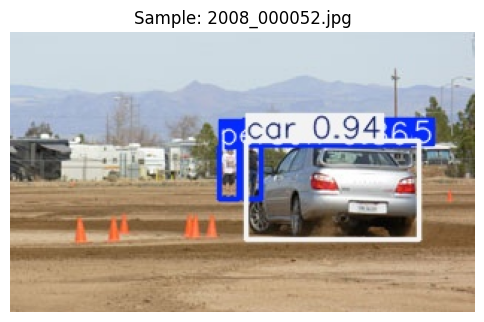

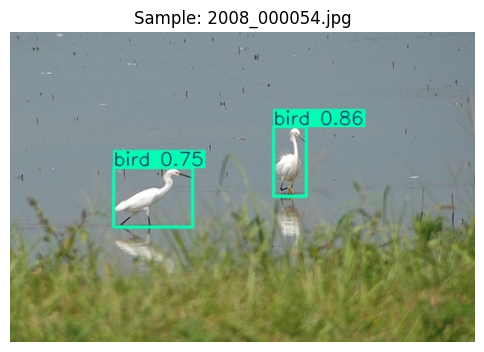

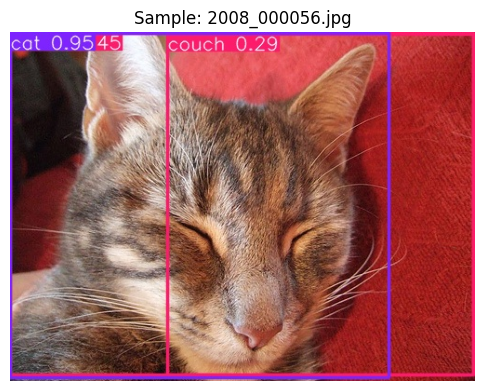

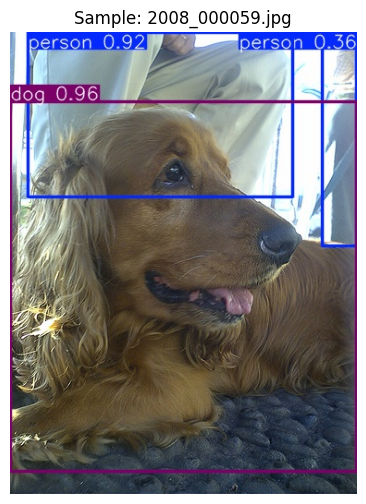

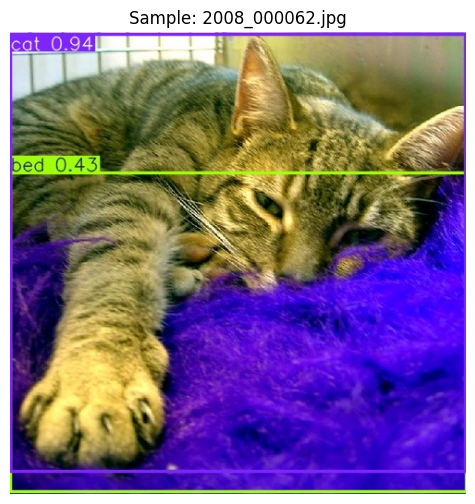

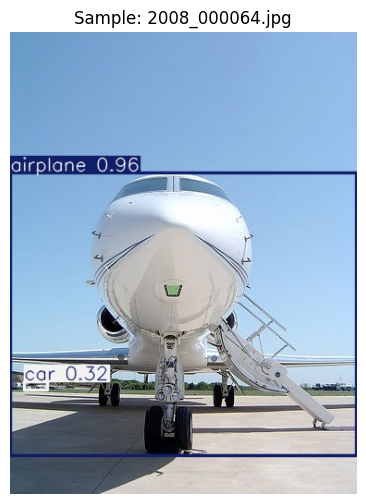

In [81]:
img_dir = "/kaggle/working/yolo11_inference/JPEGImages_preds"

# Pick some images
files = sorted([f for f in os.listdir(img_dir) 
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))])[:20]

# Display each as its own figure
for fname in files:
    img_path = os.path.join(img_dir, fname)
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Sample: {fname}")
    plt.show()

In [82]:
# Load PASCAL ground truth as we did with COCO
coco_gt = COCO(ANNOT_PATH)
img_ids = coco_gt.getImgIds()

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


In [83]:
print(img_ids[:5])
print(len(img_ids))

[0, 1, 2, 3, 4]
5823


In [84]:
with open(ANNOT_PATH) as f:
    voc_anno = json.load(f)
# Build filename → image_id map
filename_to_id = {img["file_name"]: img["id"] for img in voc_anno["images"]}

In [85]:
COCO_TO_VOC = {
    4: 1, 1: 2, 14: 3, 8: 4, 39: 5, 5: 6, 2: 7, 15: 8, 56: 9, 20: 10,
    60: 11, 16: 12, 17: 13, 3: 14, 0: 15, 57: 16, 19: 17, 63: 18, 6: 19, 62: 20
}
coco_results = []
for filename in tqdm(os.listdir(PRED_DIR)):
    if not filename.endswith('.txt'):
        continue
    jpg_name = filename.replace('.txt', '.jpg')
    if jpg_name not in filename_to_id:
        continue
    img_id = filename_to_id[jpg_name]
    txt_file = PRED_DIR / filename
    W = H = None
    img_info = [img for img in voc_anno["images"] if img["file_name"] == jpg_name]
    if img_info:
        W, H = img_info[0]['width'], img_info[0]['height']
    else:
        continue
    with open(txt_file) as f:
        for line in f:
            cls, x_c, y_c, w, h, conf = map(float, line.split())
            cls = int(cls)
            if cls not in COCO_TO_VOC:
                continue  # Only keep classes that map to VOC-20
            category_id = COCO_TO_VOC[cls]
            x1 = (x_c - w/2) * W
            y1 = (y_c - h/2) * H
            bbox = [x1, y1, w * W, h * H]
            coco_results.append({
                "image_id": img_id,
                "category_id": category_id,
                "bbox": bbox,
                "score": conf
            })

100%|██████████| 5794/5794 [00:02<00:00, 2682.41it/s]


In [86]:
print(len(coco_results))
print(coco_results[:5])

17795
[{'image_id': 4093, 'category_id': 7, 'bbox': [102.59925, 109.8102465, 359.6135, 154.17200699999998], 'score': 0.945332}, {'image_id': 4093, 'category_id': 20, 'bbox': [261.36749999999995, 1.9745235000000014, 148.007, 117.835713], 'score': 0.673527}, {'image_id': 2022, 'category_id': 14, 'bbox': [33.87225, 87.326253, 98.4635, 90.77247], 'score': 0.906427}, {'image_id': 2022, 'category_id': 2, 'bbox': [156.56425000000002, 130.514355, 197.5365, 109.38383999999999], 'score': 0.906059}, {'image_id': 2022, 'category_id': 2, 'bbox': [0.08324999999999999, 135.3869775, 47.0743, 71.753175], 'score': 0.898901}]


In [87]:
# Write out the JSON
with open(OUTPUT_JSON, "w") as f:
    json.dump(coco_results, f)
print(f"Saved {len(coco_results)} predictions → {OUTPUT_JSON}")

Saved 17795 predictions → /kaggle/working/yolo11_preds.json


In [88]:
# Run COCOeval
coco_dt = coco_gt.loadRes(OUTPUT_JSON)
evaluator = COCOeval(coco_gt, coco_dt, iouType='bbox')
evaluator.params.imgIds = img_ids   # evaluate on the same set
evaluator.evaluate()                # run per-image matching
evaluator.accumulate()              # accumulate stats
evaluator.summarize()               # print mAP, AP@.50, etc.

Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=5.13s).
Accumulating evaluation results...
DONE (t=0.86s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.552
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.663
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.596
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.196
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.427
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.627
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.441
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.593
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.595
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=10

In [89]:
def evaluate_iou_greedy(results_json, coco_gt):
    with open(results_json, "r") as f:
        results = json.load(f)

    preds_by_image = defaultdict(list)
    for pred in results:
        preds_by_image[pred["image_id"]].append(pred)

    iou_scores = []
    image_ids = list(preds_by_image.keys())

    for image_id in image_ids:
        preds = preds_by_image[image_id]
        pred_boxes = [pred["bbox"] for pred in preds]
        if len(pred_boxes) == 0:
            continue
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
        pred_boxes_xyxy = pred_boxes.clone()
        pred_boxes_xyxy[:, 2] += pred_boxes_xyxy[:, 0]
        pred_boxes_xyxy[:, 3] += pred_boxes_xyxy[:, 1]

        ann_ids = coco_gt.getAnnIds(imgIds=image_id)
        anns = coco_gt.loadAnns(ann_ids)
        gt_boxes = [ann["bbox"] for ann in anns]
        if len(gt_boxes) == 0:
            continue
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_boxes_xyxy = gt_boxes.clone()
        gt_boxes_xyxy[:, 2] += gt_boxes_xyxy[:, 0]
        gt_boxes_xyxy[:, 3] += gt_boxes_xyxy[:, 1]

        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy)
        max_ious, _ = ious.max(dim=1)
        iou_scores.extend(max_ious.cpu().numpy())
    
    mean_iou = np.mean(iou_scores) if iou_scores else 0.0
    boxes_count = len(iou_scores)
    return boxes_count, mean_iou

boxes_count, iou = evaluate_iou_greedy(OUTPUT_JSON, coco_gt)
print(f"Number of boxes: {boxes_count}")
print(f"Mean IoU = {iou:.4f}")

Number of boxes: 15162
Mean IoU = 0.8003


In [90]:
def evaluate_iou_hungarian(results_json, coco_gt):
    with open(results_json, "r") as f:
        results = json.load(f)

    preds_by_image = defaultdict(list)
    for pred in results:
        preds_by_image[pred["image_id"]].append(pred)

    iou_scores = []
    image_ids = list(preds_by_image.keys())

    for image_id in image_ids:
        preds = preds_by_image[image_id]
        pred_boxes = [pred["bbox"] for pred in preds]
        if len(pred_boxes) == 0:
            continue
        pred_boxes = torch.tensor(pred_boxes, dtype=torch.float32)
        pred_boxes_xyxy = pred_boxes.clone()
        pred_boxes_xyxy[:, 2] += pred_boxes_xyxy[:, 0]
        pred_boxes_xyxy[:, 3] += pred_boxes_xyxy[:, 1]

        ann_ids = coco_gt.getAnnIds(imgIds=image_id)
        anns = coco_gt.loadAnns(ann_ids)
        gt_boxes = [ann["bbox"] for ann in anns]
        if len(gt_boxes) == 0:
            continue
        gt_boxes = torch.tensor(gt_boxes, dtype=torch.float32)
        gt_boxes_xyxy = gt_boxes.clone()
        gt_boxes_xyxy[:, 2] += gt_boxes_xyxy[:, 0]
        gt_boxes_xyxy[:, 3] += gt_boxes_xyxy[:, 1]

        ious = box_iou(gt_boxes_xyxy, pred_boxes_xyxy).cpu().numpy()
        if ious.size == 0:
            continue

        # Hungarian matching (maximize IoU, so minimize -IoU)
        cost_matrix = -ious
        row_ind, col_ind = linear_sum_assignment(cost_matrix)
        matched_ious = ious[row_ind, col_ind]
        iou_scores.extend(matched_ious)

    mean_iou = np.mean(iou_scores) if iou_scores else 0.0
    boxes_count = len(iou_scores)
    return boxes_count, mean_iou

boxes_count, iou = evaluate_iou_hungarian(OUTPUT_JSON, coco_gt)
print(f"Number of boxes: {boxes_count}")
print(f"Mean IoU (Hungarian) = {iou:.4f}")

Number of boxes: 14168
Mean IoU (Hungarian) = 0.8453


In [91]:
def visualize_yolo_feature_maps_and_boxes(
    img_path, model, device, layer_idxs=[4, 8, 16], threshold=0.5
):
    # Register hooks to get feature maps
    feature_maps = {}
    hooks = []
    def get_activation(idx):
        def hook(module, input, output):
            feature_maps[idx] = output.detach().cpu()
        return hook
    for idx in layer_idxs:
        hooks.append(model.model.model[idx].register_forward_hook(get_activation(idx)))

    # Load and preprocess image (YOLO standard: 640x640 by default)
    im = Image.open(img_path).convert('RGB')
    orig_w, orig_h = im.size
    input_size = 640
    transform = transforms.Compose([
        transforms.Resize((input_size, input_size)),
        transforms.ToTensor(),
    ])
    img_resized = transform(im).unsqueeze(0).to(device)

    # Forward pass
    with torch.no_grad():
        results = model(img_resized)
    for h in hooks:
        h.remove()

    # Extract predictions
    try:
        preds = results[0].boxes  # Ultralytics YOLOv8
    except AttributeError:
        preds = results[0]        # fallback for older

    boxes = preds.xyxy.cpu().numpy()        # [N, 4], x1,y1,x2,y2 IN 640x640 space
    scores = preds.conf.cpu().numpy()
    labels = preds.cls.cpu().numpy()

    # Threshold and rescale coordinates to original image
    mask = scores >= threshold
    boxes = boxes[mask]
    scores = scores[mask]
    labels = labels[mask]

    # Scale boxes to original image size
    scale_w = orig_w / input_size
    scale_h = orig_h / input_size
    boxes_scaled = boxes.copy()
    boxes_scaled[:, [0, 2]] *= scale_w
    boxes_scaled[:, [1, 3]] *= scale_h

    # Plot feature maps from selected layers
    plt.figure(figsize=(len(layer_idxs) * 5, 4))
    for i, idx in enumerate(layer_idxs):
        fmap = feature_maps[idx][0]          # [C, H, W]
        fmap_mean = fmap.mean(0)
        plt.subplot(1, len(layer_idxs), i+1)
        plt.imshow(fmap_mean, cmap='viridis')
        plt.title(f"Feature map mean: Layer {idx}")
        plt.axis('off')
    plt.show()

    # Show predicted boxes on original image
    fig, axs = plt.subplots(1, 2, figsize=(18, 9))
    axs[0].imshow(im)
    ax = axs[0]
    for box, score in zip(boxes_scaled, scores):
        x1, y1, x2, y2 = box
        w, h = x2 - x1, y2 - y1
        rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor="r", facecolor="none")
        ax.add_patch(rect)
        ax.text(
            x1, y1, f"{score:.2f}",
            color="white", fontsize=8,
            bbox=dict(facecolor="red", alpha=0.5)
        )
    ax.axis("off")
    ax.set_title("Predicted bounding boxes")

    # Overlay last layer's mean feature map as heatmap on original image
    fmap = feature_maps[layer_idxs[-1]][0]
    fmap_mean = fmap.mean(0).numpy()
    heatmap = (fmap_mean - fmap_mean.min()) / (fmap_mean.max() - fmap_mean.min() + 1e-8)
    heatmap_resized = np.array(
        Image.fromarray((heatmap * 255).astype(np.uint8)).resize(im.size, resample=Image.BILINEAR)
    ) / 255.0

    axs[1].imshow(im)
    axs[1].imshow(heatmap_resized, cmap='jet', alpha=0.5)
    axs[1].axis('off')
    axs[1].set_title(f"Feature map heatmap: layer {layer_idxs[-1]}")

    plt.tight_layout()
    plt.show()

In [92]:
for idx, layer in enumerate(model.model.model):
    print(f"Layer {idx}: {type(layer)}")

Layer 0: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 1: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 2: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 3: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 4: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 5: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 6: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 7: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 8: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 9: <class 'ultralytics.nn.modules.block.SPPF'>
Layer 10: <class 'ultralytics.nn.modules.block.C2PSA'>
Layer 11: <class 'torch.nn.modules.upsampling.Upsample'>
Layer 12: <class 'ultralytics.nn.modules.conv.Concat'>
Layer 13: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 14: <class 'torch.nn.modules.upsampling.Upsample'>
Layer 15: <class 'ultralytics.nn.modules.conv.Concat'>
Layer 16: <class 'ultralytics.nn.modules.block.C3k2'>
Layer 17: <class 'ultralytics.nn.modules.conv.Conv'>
Layer 18: <class 'ultralytics.nn.mo


0: 640x640 2 birds, 49.8ms
Speed: 0.0ms preprocess, 49.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to /kaggle/working/yolo11_inference/JPEGImages_preds
5795 labels saved to /kaggle/working/yolo11_inference/JPEGImages_preds/labels


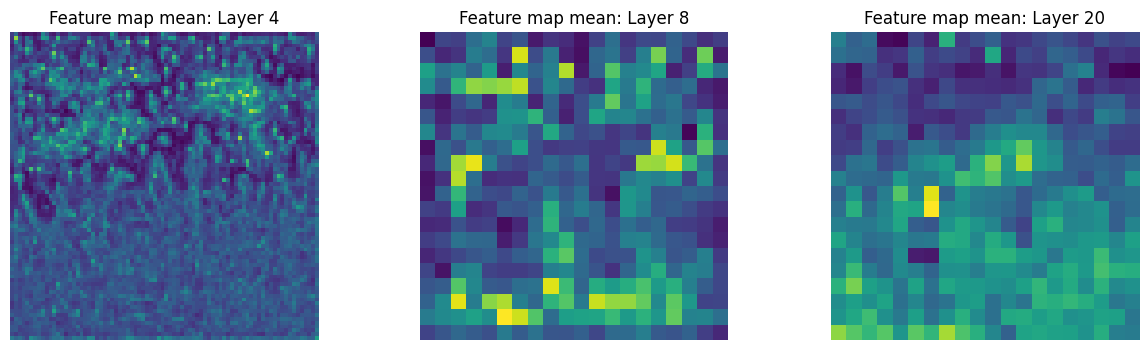

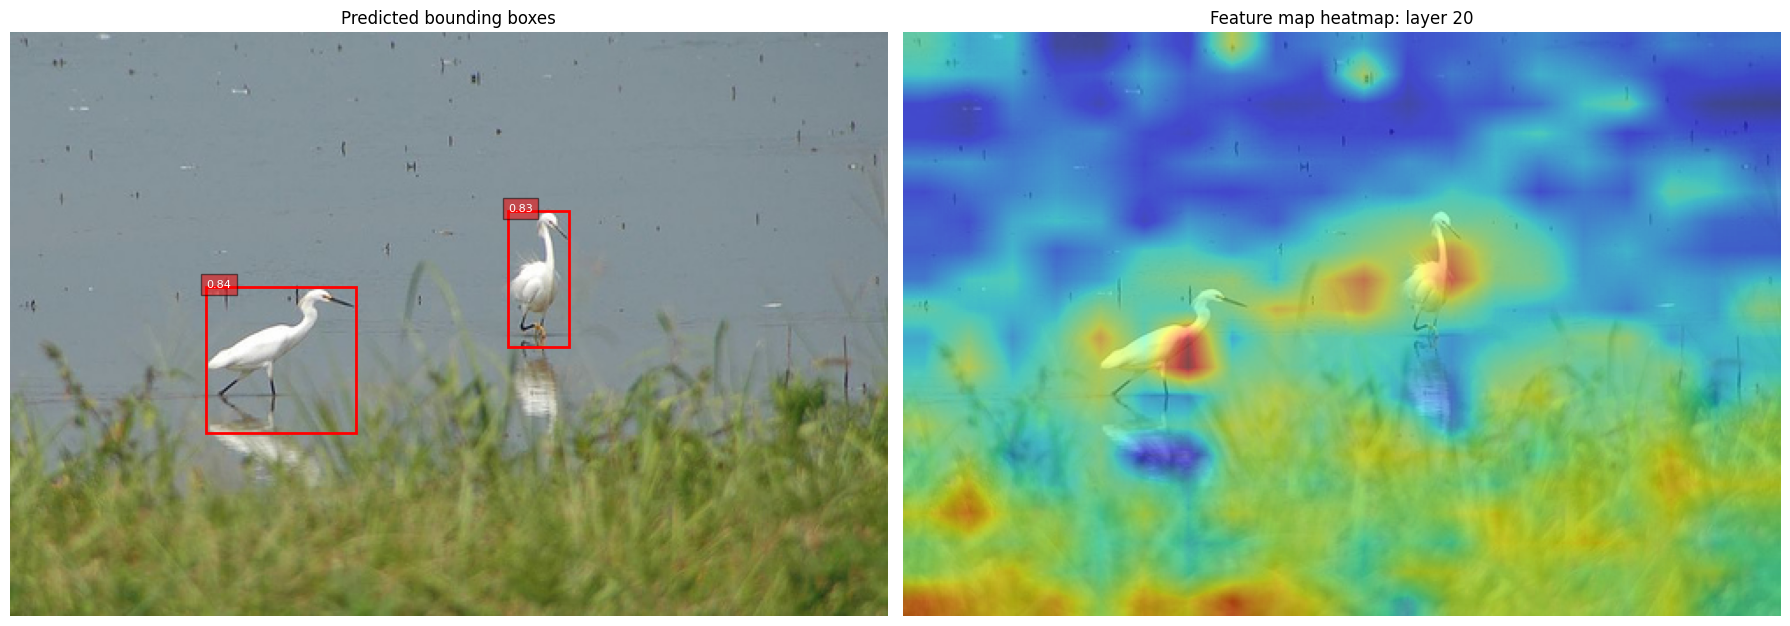

In [95]:
img_path = '/kaggle/working/voc2012_val_images/2008_000054.jpg'
visualize_yolo_feature_maps_and_boxes(
    img_path, model, device, layer_idxs=[4, 8, 20], threshold=0.5
)